In [123]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import argparse
import seaborn as sns

from scipy import stats
from scipy import fftpack



%matplotlib inline
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('../data/shot_logs.csv', header=0)

In [3]:
df.columns

Index([u'GAME_ID', u'MATCHUP', u'LOCATION', u'W', u'FINAL_MARGIN',
       u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK', u'SHOT_CLOCK', u'DRIBBLES',
       u'TOUCH_TIME', u'SHOT_DIST', u'PTS_TYPE', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER', u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST',
       u'FGM', u'PTS', u'player_name', u'player_id'],
      dtype='object')

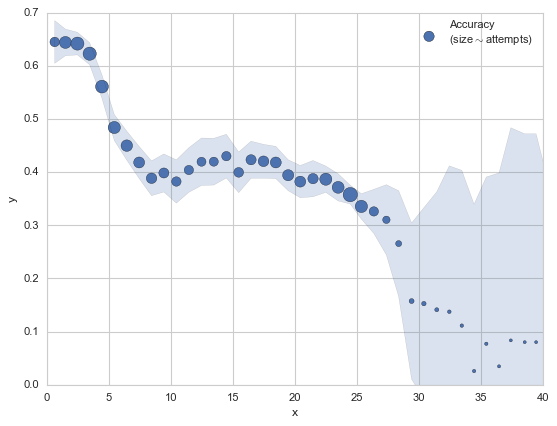

In [4]:
fig, ax = plt.subplots()

group_df = df.loc[:, ['FGM',"SHOT_DIST"]].groupby(np.digitize(df.loc[:,'SHOT_DIST'], np.linspace(0,40,41)) )
df_AccDist = pd.concat([group_df.mean().rename(columns={"SHOT_DIST":"x", "FGM":"y"}),
                        group_df.std().rename(columns={"SHOT_DIST":"xerr", "FGM":"yerr"}),
                        group_df.count().rename(columns={"SHOT_DIST":"xcount", "FGM":"ycount"})],
                       axis=1)
df_AccDist.loc[:, "xerr"] = df_AccDist.loc[:, "xerr"]/np.sqrt(df_AccDist.loc[:, "xcount"])
df_AccDist.loc[:, "yerr"] = 1./np.sqrt(df_AccDist.loc[:, "ycount"])
df_AccDist = df_AccDist.loc[:, ["x", "y", "xerr", "yerr", "xcount"]]


df_AccDist.plot(kind='scatter', x="x", y="y", figsize=(8,6), ax=ax,
                s=1.5*np.sqrt(df_AccDist.xcount), ylim=(0,0.7), xlim=(0,40),
                label="Accuracy\n(size$\sim$attempts)")
plt.fill_between(df_AccDist.x, df_AccDist.y-1.96*df_AccDist.yerr, df_AccDist.y+1.96*df_AccDist.yerr, alpha=0.2)


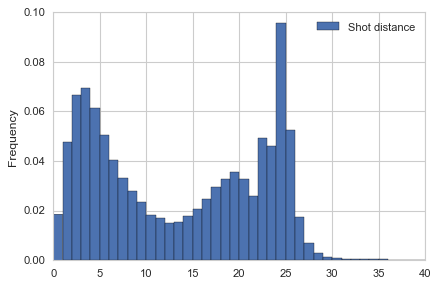

In [5]:
df.plot(kind='hist', y='SHOT_DIST', bins=np.linspace(0,40,41), xlim=(0,40), label="Shot distance", normed=True)


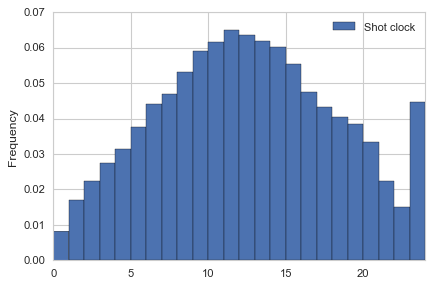

In [6]:
df.plot(kind='hist', y='SHOT_CLOCK', bins=np.linspace(0,24,25), xlim=(0,24), label="Shot clock", normed=True)

In [7]:
def getOffenseTeam(input):
        if input.find('@')!=-1:
            team = (input.split(' - ')[1]).split(' @ ')[0]
            return team
        else:
            team = (input.split(' - ')[1]).split(' vs. ')[0]
            return team

def getDefenseTeam(input):
        if input.find('@')!=-1:
            team = (input.split(' - ')[1]).split(' @ ')[1]
            return team
        else:
            team = (input.split(' - ')[1]).split(' vs. ')[1]
            return team

In [8]:
df['SHOOTING_TEAM'] = df.loc[:,'MATCHUP'].apply(getOffenseTeam)
df['DEFENSE_TEAM']  = df.loc[:,'MATCHUP'].apply(getDefenseTeam)

In [9]:
def getTeam(df, team):
    return df.loc[df['SHOOTING_TEAM']==team]

df['SHOOTING_TEAM'].unique()

array(['CHA', 'MIN', 'UTA', 'OKC', 'LAL', 'GSW', 'ATL', 'WAS', 'SAC',
       'NOP', 'TOR', 'DAL', 'ORL', 'CLE', 'IND', 'BOS', 'PHX', 'MEM',
       'SAS', 'POR', 'DEN', 'MIA', 'PHI', 'MIL', 'HOU', 'NYK', 'DET',
       'LAC', 'CHI', 'BKN'], dtype=object)

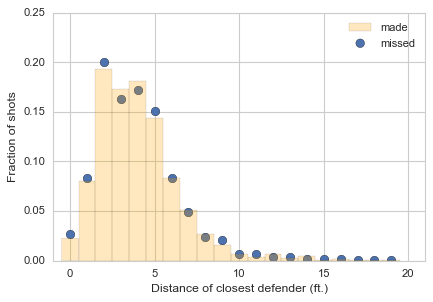

In [10]:
def plotTeam(df, team):
    fig, ax = plt.subplots()
    team_df = getTeam(df, team)
    bins = np.arange(-0.5,20.5,1)
    plot_df = team_df.query('FGM== 1  & CLOSE_DEF_DIST <= 20')
    plot_df.loc[:, "CLOSE_DEF_DIST"].plot(kind='hist', bins=bins, ax=ax,
                                          label='made', alpha=0.25,
                                          normed=1, ylim=(0,0.25),
                                          xlim=(-1,21), color='orange')

    plot_df = team_df.query('FGM == 0 & CLOSE_DEF_DIST <= 20')
    plot_df = plot_df.loc[:, "CLOSE_DEF_DIST"].value_counts(normalize=True,
                                                            bins=bins)
    plot_df.index = plot_df.index.rename("bins") + 0.5
    plot_df = plot_df.to_frame().reset_index()
    plot_df.plot(kind='scatter', x='bins', ax = ax, s=60,
                 y='CLOSE_DEF_DIST', label='missed')

    ax.set_xlabel("Distance of closest defender (ft.)")
    ax.set_ylabel("Fraction of shots")
    plt.legend(loc=1)

plotTeam(df, "BOS")

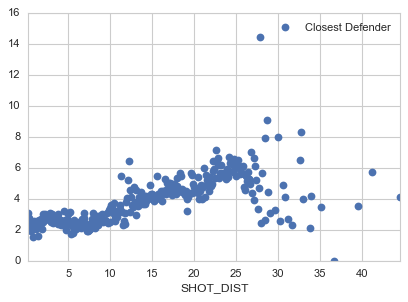

In [13]:
group_df = getTeam(df, "BOS").loc[:,['SHOT_DIST','CLOSE_DEF_DIST']].groupby('SHOT_DIST')
group_df.mean().plot(y="CLOSE_DEF_DIST", 
                     style='o', label="Closest Defender")

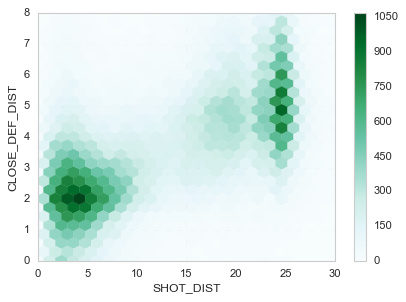

In [14]:
graph_df = df.loc[(df['SHOT_DIST']<=30) & (df['CLOSE_DEF_DIST']<=8), 
                  ['SHOT_DIST','CLOSE_DEF_DIST']]
graph_df.plot.hexbin(x='SHOT_DIST', y='CLOSE_DEF_DIST',
                     gridsize=25, sharex=False,
                     xlim=(0,30), ylim=(0,8))

In [15]:
def clock_conv(x):
    try:
        time = x.split(':')
        time = map(float, time)
        return time[0] + time[1]/60.
    except:
        return x

df.loc[:, "GAME_CLOCK"] = df.loc[:, "GAME_CLOCK"].apply(clock_conv)
df.loc[:, "SHOT_CLOCK"] = df.loc[:, "SHOT_CLOCK"].fillna(df.loc[:, "GAME_CLOCK"]).apply(clock_conv)

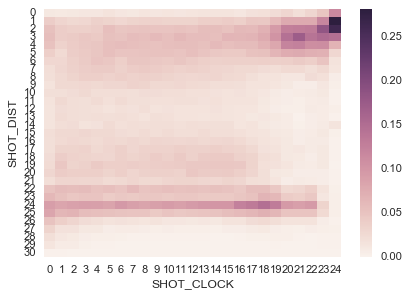

In [16]:
# Shot distance vs shot clock histogram, normalized to shot clock.
sns.heatmap(
    pd.crosstab(
        (df.loc[(df['SHOT_DIST']<=30), 'SHOT_DIST']).apply(np.int),
        (df.loc[(df['SHOT_DIST']<=30), 'SHOT_CLOCK']).apply(np.int), 
        normalize='columns'))

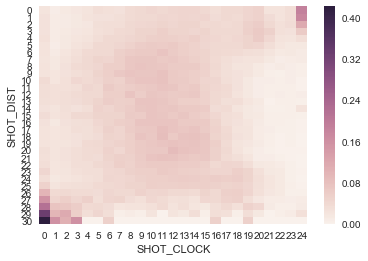

In [238]:
# Shot distance vs shot clock histogram, normalized to shot distance.
sns.heatmap(
    pd.crosstab(
        (df.loc[(df['SHOT_DIST']<=30), 'SHOT_DIST']).apply(np.int),
        (df.loc[(df['SHOT_DIST']<=30), 'SHOT_CLOCK']).apply(np.int), 
        normalize='index'))

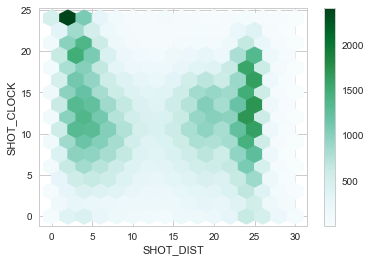

In [241]:
df.loc[(df['SHOT_DIST']<=30), 
       ['SHOT_DIST',
        'SHOT_CLOCK']].plot.hexbin(x='SHOT_DIST', y='SHOT_CLOCK',
                                   gridsize=15, sharex=False)

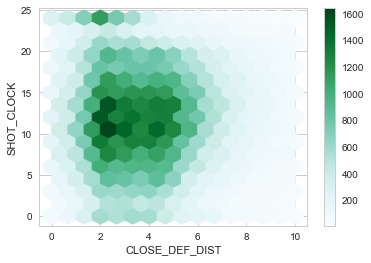

In [242]:
df.loc[(df['CLOSE_DEF_DIST']<=10), 
       ['CLOSE_DEF_DIST',
        'SHOT_CLOCK']].plot.hexbin(x='CLOSE_DEF_DIST', y='SHOT_CLOCK',
                                   gridsize=15, sharex=False)

In [301]:
# # the goal is to measure a probability that shooter X differs from the
# # average. To start I'll just focus on shots within 10 ft of the hoop,
# # and do one bin, but then want to extend to a binned analysis

# #first get the league average
# df_acc_league = df.query("SHOT_DIST < 5")
# df_acc_league= df_acc_league.loc[:,['FGM',"SHOT_DIST"]].groupby(\
#                  np.digitize(df_acc_league.loc[:,'SHOT_DIST'],
#                              np.linspace(0,5,1)))
# league_acc = df_acc_league.mean()
# league_pct = league_acc.FGM.values[0]

# #now get steph curry's percentage
# df_acc_steph = df.query("SHOT_DIST < 5 & player_name =='stephen curry'")
# df_acc_steph = df_acc_steph.loc[:,['FGM','SHOT_DIST']].groupby(\
#                  np.digitize(df_acc_steph.loc[:,'SHOT_DIST'],
#                              np.linspace(0,5,1)))
# steph_acc = df_acc_steph.mean().FGM.values[0]
# steph_std = df_acc_steph.std().FGM.values[0]

## Time difference distribution between shots and successful shots

In [19]:
# Select all made shots
df_sc_made = df.query('FGM==1')
# Calculate game time from period and game clock. 
# For that, we needed to use clock_conv() before.
df_sc_made.loc[:, "GAME_TIME"] = 12*60*df_sc_made.loc[:, "PERIOD"] \
                                 + (60*(12 - df_sc_made.loc[:, "GAME_CLOCK"]))

# Select applicable columns
df_sc_made = df_sc_made.loc[:, ("GAME_ID", "GAME_TIME", "player_name")]
# Set index such that grouping keeps player_name and GAME_ID as index.
# Rename column to INTERVAL
df_sc_made = df_sc_made.set_index(["player_name", "GAME_ID"])
df_sc_made = df_sc_made.groupby(level=["player_name", "GAME_ID"])
df_sc_made = df_sc_made.diff().rename(columns={"GAME_TIME":"INTERVAL"})

In [233]:
df_sc_missed = df.query('FGM==0')
df_sc_missed.loc[:, "GAME_TIME"] = 12*60*df_sc_missed.loc[:, "PERIOD"] \
                                   + (60*(12 - df_sc_missed.loc[:, "GAME_CLOCK"]))

df_sc_missed = df_sc_missed.loc[:, ("GAME_ID", "GAME_TIME", "player_name")]
df_sc_missed = df_sc_missed.set_index(["player_name", "GAME_ID"])
df_sc_missed = df_sc_missed.groupby(level=["player_name", "GAME_ID"])
df_sc_missed = df_sc_missed.diff().rename(columns={"GAME_TIME":"INTERVAL"})

In [65]:
df_sc_taken = df.copy()
df_sc_taken.loc[:, "GAME_TIME"] = 12*60*df_sc_taken.loc[:, "PERIOD"] \
                                   + (60*(12 - df_sc_taken.loc[:, "GAME_CLOCK"]))

df_sc_taken = df_sc_taken.loc[:, ("GAME_ID", "GAME_TIME", "player_name")]
df_sc_taken = df_sc_taken.set_index(["player_name", "GAME_ID"])
df_sc_taken = df_sc_taken.groupby(level=["player_name", "GAME_ID"])
df_sc_taken = df_sc_taken.diff().rename(columns={"GAME_TIME":"INTERVAL"})

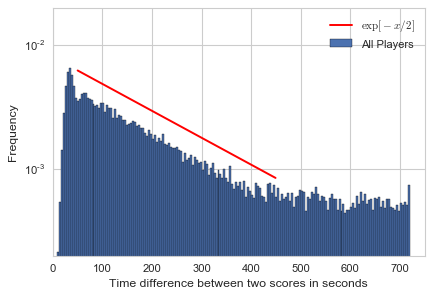

In [288]:
fig, ax = plt.subplots()
plot_df = df_sc_made.copy()
ax.set_yscale("log")
ax.set_xlabel("Time difference between two scores in seconds")

plt.plot(np.arange(50, 450), 0.008*np.exp(-0.5*np.arange(0.5, 4.5, 0.01)), 
         color='r', label='$\exp[-x/2]$')
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,750), ylim=(2e-4, 2e-2), label="All Players",
             bins=np.linspace(0,720,181), normed=1, ax=ax)
plt.legend(loc=1)

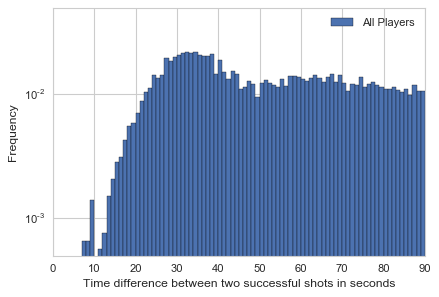

In [208]:
# Zooming into the first 90 seconds

bins = np.linspace(0,90,91)

fig, ax = plt.subplots()
plot_df = df_sc_made.loc[df_sc_made["INTERVAL"]<np.max(bins)]
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,np.max(bins)), ylim=(5e-4, 5e-2), label="All Players",
             bins=bins,normed=1, ax=ax)
ax.set_xlabel("Time difference between two successful shots in seconds")
ax.set_yscale("log")

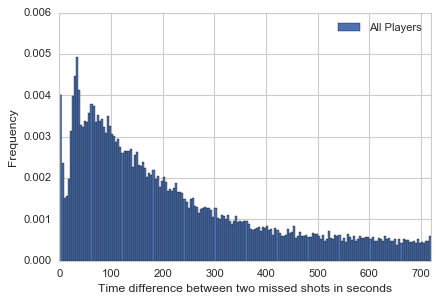

In [237]:
fig, ax = plt.subplots()
plot_df = df_sc_missed.copy()
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,720), ylim=(0, 0.006), label="All Players",
             bins=np.linspace(0,720,181),normed=1, ax=ax)
ax.set_xlabel("Time difference between two missed shots in seconds")

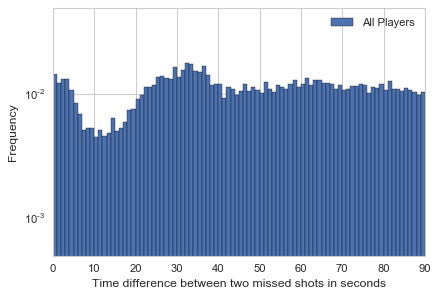

In [235]:
# Zooming into the first 90 seconds

bins = np.linspace(0,90,91)

fig, ax = plt.subplots()
plot_df = df_sc_missed.loc[df_sc_missed["INTERVAL"]<np.max(bins)]
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,np.max(bins)), ylim=(5e-4, 5e-2), label="All Players",
             bins=bins, normed=1, ax=ax)
ax.set_xlabel("Time difference between two missed shots in seconds")
ax.set_yscale("log")

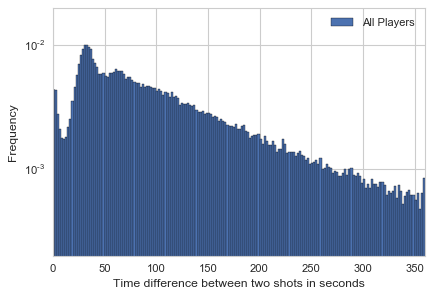

In [287]:
fig, ax = plt.subplots()
plot_df = df_sc_taken.copy()
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,360), ylim=(2e-4, 2e-2), label="All Players",
             bins=np.linspace(0,360,181),normed=1, ax=ax)
ax.set_xlabel("Time difference between two shots in seconds")
ax.set_yscale("log")

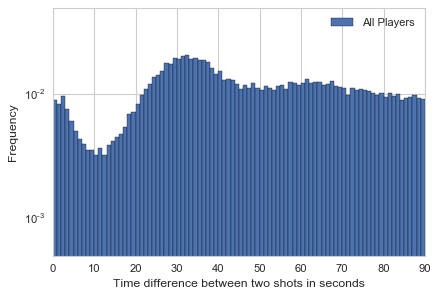

In [209]:
# Zooming into the first 90 seconds.
# There are shots in short repetition, only possible of course if the previous shot has not been made.
bins = np.linspace(0,90,91)

fig, ax = plt.subplots()
plot_df = df_sc_taken.loc[df_sc_taken["INTERVAL"]<np.max(bins)]
plot_df.plot(kind='hist',y='INTERVAL', xlim=(0,np.max(bins)), ylim=(5e-4, 5e-2), label="All Players",
             bins=bins,normed=1, ax=ax)
ax.set_xlabel("Time difference between two shots in seconds")
ax.set_yscale("log")

### Statistical testing between shots taken and shots made
Is there are difference in the distributions of the shots taken and the shots made between 20 and 90 seconds?
Here, we omit the first 20 seconds because after a successful shot, the ball is turned over.
We find that, at a confidence level of 98 percent, the distributions are the same for all players.
Does this hint at the lack of hot streaks?

In [227]:
# 2-sample Kolmogorov-Smirnov test
stats.ks_2samp(df_sc_made.query("INTERVAL<"+str(np.max(bins))+" & INTERVAL>=20").loc[:,
                               "INTERVAL"].value_counts(True, True, bins=bins).sort_index().values,
               df_sc_taken.query("INTERVAL<"+str(np.max(bins))+" & INTERVAL>=20").loc[:,
                               "INTERVAL"].value_counts(True, True, bins=bins).sort_index().values)

Ks_2sampResult(statistic=0.066666666666666652, pvalue=0.9853244814126525)

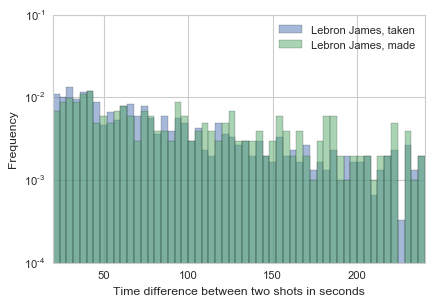

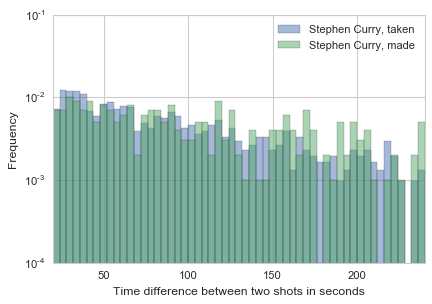

In [243]:
player = "'lebron james'"
fig, ax = plt.subplots()
plot_df = df_sc_taken.query("player_name == " + player)
plot_df.plot(kind='hist',y='INTERVAL', xlim=(20,240), label="Lebron James, taken",
             bins=np.linspace(0,240,61),normed=1, ax=ax, alpha=0.5)
plot_df = df_sc_made.query("player_name == " + player)
plot_df.plot(kind='hist',y='INTERVAL', xlim=(20,240), label="Lebron James, made",
             bins=np.linspace(0,240,61),normed=1, ax=ax, alpha=0.5)
ax.set_xlabel("Time difference between two shots in seconds")

ax.set_yscale("log")

player = "'stephen curry'"
fig, ax = plt.subplots()
plot_df = df_sc_taken.query("player_name == " + player)
plot_df.plot(kind='hist',y='INTERVAL', xlim=(20,240), label="Stephen Curry, taken",
             bins=np.linspace(0,240,61), normed=1, ax=ax, alpha=0.5)
plot_df = df_sc_made.query("player_name == " + player)
plot_df.plot(kind='hist',y='INTERVAL', xlim=(20,240), label="Stephen Curry, made",
             bins=np.linspace(0,240,61), normed=1, ax=ax, alpha=0.5)
ax.set_xlabel("Time difference between two shots in seconds")

ax.set_yscale("log")

# Maybe, though, it doesn't make sense to compare different players from different positions!?

How many shots after a successful shot does it take to score the next time?
Find the standard deviation per player per game. It's lognormal.

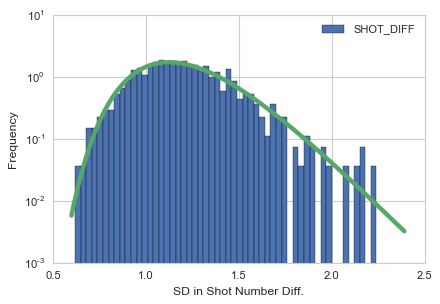

In [373]:
df_made = df.loc[df["FGM"]==1, ("GAME_ID", "SHOT_NUMBER", 
                                "GAME_CLOCK", "player_id")].set_index(["player_id", "GAME_ID"])
df_made = df_made.groupby(level=["player_id", "GAME_ID"]).diff() - 1
df_made.columns = ["SHOT_DIFF", "TIME_DIFF"]

fig, ax = plt.subplots()

plot_df = df_made.dropna().reset_index().loc[:, ("GAME_ID", "SHOT_DIFF")].groupby("GAME_ID").std()
plot_df.plot(kind='hist', bins=np.arange(0.5, 2.5, 0.03),  ax=ax, normed=True)

plt.plot(np.arange(0.6, 2.4, 0.01), stats.lognorm.pdf(np.arange(0.6, 2.4, 0.01), 0.24, 0.18), linewidth=4)
ax.set_yscale("log")
ax.set_xlabel("SD in Shot Number Diff.")

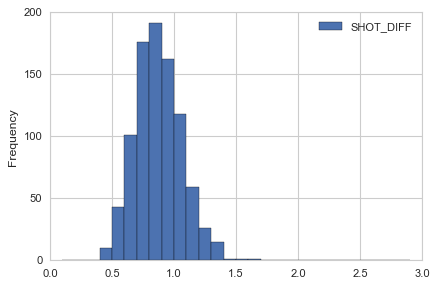

In [379]:
plot_df = df_made.dropna().reset_index().loc[:, ("GAME_ID", "SHOT_DIFF")].groupby("GAME_ID").mean()
plot_df.plot(kind='hist', bins=np.arange(0,3,0.1))

In [ ]:
print len(df)
#take first 80% as training - 10% for validation; 10% for testing
#first randomize so it's not all one shooter

df_input = df.loc[:,['SHOT_DIST','CLOSE_DEF_DIST','DRIBBLES','SHOT_CLOCK','FGM','TOUCH_TIME']].dropna()
print len(df_input)
df_rand = df_input.sample(frac=1)
df_rand = df_rand.sample(frac=1)
df_rand = df_rand.sample(frac=1)

df_train = df_rand.iloc[0:104000,:]
df_val = df_rand.iloc[104001:115000,:]
df_test = df_rand.iloc[115001:,:]

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

def getTrainData(nVar):
    ExamplesTrain = df_train.loc[:,['SHOT_DIST','CLOSE_DEF_DIST','DRIBBLES','SHOT_CLOCK','TOUCH_TIME']].as_matrix()
    #now the signal
    ResultsTrain = df_train.loc[:,['FGM']].as_matrix()
    return (ExamplesTrain,ResultsTrain)

def getTestData(nVar):
    ExamplesTest = df_test.loc[:,['SHOT_DIST','CLOSE_DEF_DIST','DRIBBLES', 'SHOT_CLOCK','TOUCH_TIME',]].as_matrix()
    #now the signal
    ResultsTest = df_test.loc[:,'FGM'].as_matrix()
    return (ExamplesTest,ResultsTest)


In [ ]:
def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l1",alpha=alpha)
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    print 'Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test))
    probs = clf.predict_proba(X_test)
    train_probs = clf.predict_proba(X_train)
    #print probs
    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance = []
    BkgRejection = []
    print y_test
    for thresh in thresholds:
        it=0
        nPredSig=0.0
        nPredBkg=0.0
        nTotSig=0.0
        nTotBkg=0.0        
        for prob in probs:
            if prob[1]>thresh:
                predSig=True
            else:
                predSig=False
            if y_test[it]:
                Sig = True
            else:
                Sig = False
            if Sig:
                if predSig:
                    nPredSig+=1
                nTotSig+=1
            else:
                if not predSig:
                    nPredBkg+=1
                nTotBkg+=1
            it+=1
        Acceptance.append(nPredSig/nTotSig)
        BkgRejection.append(nPredBkg/nTotBkg)
    return (Acceptance,BkgRejection,probs,train_probs)

In [ ]:
accep,rej,probsTest,probsTrain = runSciKitRegressionL1(0,0.1)

In [ ]:
plt.scatter(accep,rej)

In [ ]:
df_train.loc[:,'PROB']=probsTrain[:,1]

In [ ]:
df_train.plot(kind='scatter',x='CLOSE_DEF_DIST',y='PROB')

In [ ]:
df_train.plot(kind='scatter',x='SHOT_CLOCK',y='PROB')

In [ ]:
df_train.plot(kind='scatter',x='DRIBBLES',y='PROB')

In [ ]:
df_train.plot(kind='scatter',x='SHOT_DIST',y='PROB')

In [ ]:
df_train.plot(kind='scatter',x='TOUCH_TIME',y='PROB')

In [ ]:
from difflib import SequenceMatcher
from bs4 import BeautifulSoup
import requests

url = "http://hoopshype.com/2015/11/05/these-are-the-ratings-of-all-players-in-nba-2k16/"
file = requests.get(url)
main = BeautifulSoup(file.content, 'html.parser')
main = main.find("div", {"class":"articleBody"})
main = main.find("table")

player_list = []
for td in main.find_all("tr", {"style":"font-size:11px;"}):
    try:
        entry = td.find("a")
    except:
        continue
    name = entry.text
    strength = entry.parent.nextSibling.nextSibling.text
    try:
        strength = np.int(strength)
    except:
        continue
    player = [name.lower(), strength]
    player_list.append(player)
    
nba_player_df = pd.DataFrame(player_list, columns=["Name", "Strength"])
players_df = df.loc[:, ["player_name", "player_id"]].groupby("player_name").first().reset_index()

merged_players_df = pd.merge(nba_player_df, players_df, 
                             left_on="Name", right_on="player_name").loc[:,["player_id", "Strength"]]

In [ ]:
list_a = [[i,s] for i, s in enumerate(nba_player_df.loc[:, "Name"].values.tolist())]
list_b = [[i,s] for i, s in enumerate(players_df.loc[:, "player_name"].values.tolist())]

pairs = []
for ii in range(len(list_a)):
    for jj in range(len(list_b)):
        m = SequenceMatcher(None, list_a[ii][1], list_b[jj][1])
        if m.ratio() > 0.85:
            pairs.append([ii,jj, list_a[ii][1], list_b[jj][1], m.ratio()])
            if m.ratio() == 1:
                break